In [2]:
import data as d

In [61]:
data_list = d.get_data(250, 16, 25, 200)

2818.06952
2377.20512


In [62]:
import fft_tools as fft_t
import imp
imp.reload(fft_t)

<module 'fft_tools' from 'C:\\Users\\d073982\\Documents\\GitHub\\ModelTreeGRU\\fft_tools.py'>

In [63]:
transformed = fft_t.signal_batch_to_ffts(data_list[0], 200)

In [64]:
import matplotlib.pyplot as plt

In [66]:
transformed.shape

(250, 16, 202)

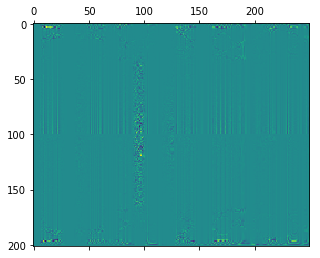

In [67]:
plt.matshow(transformed[:, 1, :].T, aspect='auto')

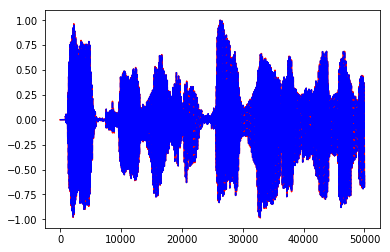

In [68]:
inverted = fft_t.invert_fft_batch(transformed)
inverted.shape
plt.plot(inverted[1],'r-', data_list[0][:,1,:].reshape(-1), 'b--')

4.410812217069357

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import model_gru as m
import tree_net_sequential as TN
import imp
import datetime

imp.reload(TN)

<module 'tree_net_sequential' from 'C:\\Users\\Hendrik\\Documents\\GitHub\\ModelTreeGRU\\tree_net_sequential.py'>

In [27]:
tree_n = TN.TreeNet([400, 800], 202, [25, 10], 0.001)

In [28]:
tree_n.get_data_for_level(torch.from_numpy(data_list[0]).float().cuda(), 1).shape

torch.Size([100, 16, 50])

### Training Function

In [2]:
def train(data, level, epochs = 500):
    td = {}
    loss_f = nn.MSELoss()
    
    for e in range(epochs):
        avg_loss = 0.0

        for i, b in enumerate(data):
            if i not in td:
                data = tree_n.get_data_for_level(torch.from_numpy(b).float().cuda(), level)
                td[i] = data
            else:
                data = td[i]

            b_loss = 0.0

            for m in range(data.shape[0] // tree_n.time_steps_level[level]):

                s = data[m*tree_n.time_steps_level[level] : (m+1) * tree_n.time_steps_level[level]]

                tree_n.zero_grad()

                state = tree_n.forward(s, level)
                pred = tree_n.backward(state, level)

                loss = loss_f(pred, s)
                loss.backward()

                b_loss += loss

                tree_n.optimizers[level].step()

            b_loss /= tree_n.time_steps_level[level]

            print("Batch loss", b_loss)

            avg_loss += b_loss
            
        avg_loss /= len(data_list)
    
        print(e, avg_loss)
    
    time_str = datetime.datetime.now().strftime("%I:%M%p-on-%B-%d-%Y")
    
    torch.save(tree_n.encoders[level], "models/seq_tn/encoder-"+time_str+"-L"+str(level)+".mdl")
    torch.save(tree_n.decoders[level], "models/seq_tn/decoder-"+time_str+"-L"+str(level)+".mdl")

### Training level 0

In [ ]:
train(transformed, 0)

### Training Level 1

In [ ]:
train(transformed, 1)

### Training Level 2

In [ ]:
train(transformed, 2)

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import write

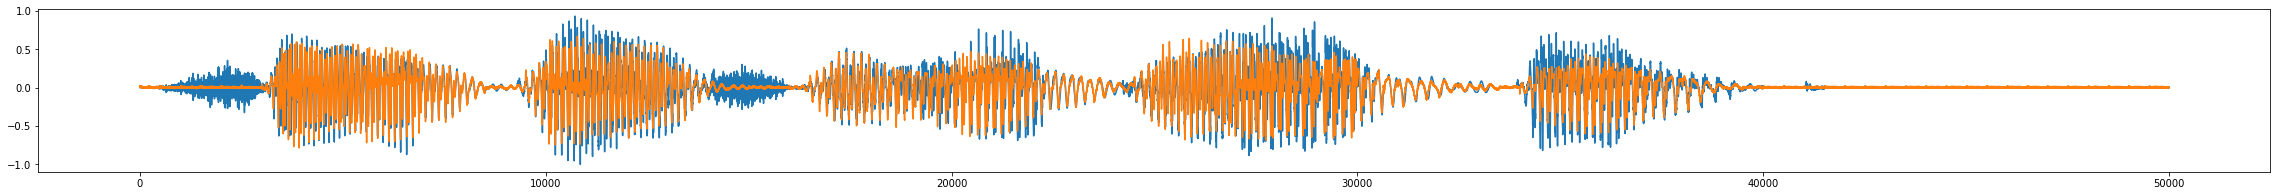

In [70]:
idx = 9

in_data = data_list[0]
out_data = apply(torch.from_numpy(in_data).float().cuda())

plt.rcParams["figure.figsize"] = (40,3)
plt.plot(in_data[:,idx,:].reshape((-1,)))
plt.plot(out_data[:,idx,:].cpu().detach().numpy().reshape((-1,)))

In [71]:
idx = 9
np_data_out = out_data[:,idx,:].cpu().detach().numpy().reshape((-1,))
np_data_in = in_data[:,idx,:].reshape((-1,))
scaled_out = np.int16(np_data_out/np.max(np.abs(np_data_out)) * 32767)
scaled_in = np.int16(np_data_in/np.max(np.abs(np_data_in)) * 32767)

write('test_in.wav', 24000, scaled_in)
write('test_out.wav', 24000, scaled_out)